In [43]:
import hydra
from omegaconf import OmegaConf
from glob import  glob
# from rosa import  predict
from rosa.data import create_io_paths, RosaDataModule
from rosa.modeling.modules import RosaLightningModule
from pytorch_lightning import Trainer


BASE_DIR = "/Users/nsofroniew/Documents/data/rosa/outputs/2023-02-12/21-57-00"
config_dir = BASE_DIR + "/.hydra"

with hydra.initialize_config_dir(config_dir=config_dir):
    config = hydra.compose(config_name="config", overrides=OmegaConf.load(config_dir + "/overrides.yaml"))

    chkpts = BASE_DIR + "/checkpoints/*.ckpt"
    chkpt = glob(chkpts)[1]

    _, output_path = create_io_paths(config.paths)

    # Create Data Module
    rdm = RosaDataModule(
        output_path,
        config=config.data_module,
    )
    rdm.setup()

    # Load model from checkpoint
    rlm = RosaLightningModule.load_from_checkpoint(
        chkpt,
        in_dim=rdm.len_input,
        out_dim=rdm.len_target,
        config=config.module,
    )
    print(rlm)

    trainer = Trainer()
    predictions = trainer.predict(rlm, rdm)
    rdm.predict_dataset.predict(predictions)
    adata = rdm.predict_dataset.adata
    # adata = predict(config, chkpt)

display(adata)

Global seed set to 0
/Users/nsofroniew/opt/anaconda3/envs/multiomics/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/nsofroniew/opt/anaconda3/envs/multiomics/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)
/var/folders/6n/b_zkz2ns3_l02s3g4lnlklxr0000gq/T/ipykernel_48195/309743568.py:13: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume 

RosaLightningModule(
  (model): RosaSingleModel(
    (main): Sequential(
      (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (input_embed): Identity()
      (feed_forward): Identity()
      (dropout): Dropout(p=0.5, inplace=False)
      (expression_head): ProjectionExpressionHead(
        (model): Sequential(
          (projection): Linear(in_features=256, out_features=19431, bias=True)
          (activation): Softplus(beta=1, threshold=20)
        )
      )
    )
  )
)


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/nsofroniew/opt/anaconda3/envs/multiomics/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1789: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
Missing logger folder: /Users/nsofroniew/Documents/GitHub/rosa/notebooks/lightning_logs
/Users/nsofroniew/opt/anaconda3/envs/multiomics/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

AnnData object with n_obs × n_vars = 369 × 19431
    obs: 'dataset_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'label', 'sample', 'n_genes', 'train', 'marker_gene', 'marker_feature_name'
    var: 'soma_joinid', 'feature_name', 'feature_length', 'column_1', 'column_2', 'column_3', 'column_4', 'external_gene_name', 'gene_biotype', 'train', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dendrogram_label', 'hvg', 'log1p', 'obs_embedding_pca', 'preprocessing', 'rank_genes_groups', 'var_embedding_pca'
    obsm: 'bin_edges', 'embedding'
    varm: 'embedding', 'embedding_pca'
    layers: 'binned', 'counts', 'log1p', 'normalized_counts', 'prediction'

In [44]:
from sklearn.decomposition import PCA


train_cells = adata.obs['train']
train_genes = adata.var['train']
adata_split = adata[train_cells, train_genes]

# fit pca on training data
pca = PCA()
pca.fit(adata_split.X)

# compute scores for all cells
pca_expression = pca.transform(adata[:, train_genes].X)

# # add cell embeddings to obsm
# n_pcs = config.pcs
# n_pcs = min(n_pcs, pca_expression.shape[1] - 1)
# adata.obsm["embedding"] = pca_expression[:, :n_pcs]
# adata.uns["obs_embedding_pca"] = {
#     "explained_variance": np.cumsum(pca.explained_variance_ratio_)[n_pcs]
# }

In [3]:
# trans = np.einsum('ij, kj -> ik', adata[:, train_genes].X - pca.mean_, pca.components_)

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [5]:
# imports from captum library
from captum.attr import IntegratedGradients, InputXGradient

In [6]:
# ig = IntegratedGradients(rlm)
ixg = InputXGradient(rlm)

In [7]:
test_input_tensor = rdm.predict_dataset[:][0]
target_tensor = rdm.predict_dataset[:][1]

In [8]:
x, y = next(iter(rdm.predict_dataloader()))

In [9]:
y.shape[-1]

19431

In [ ]:
import zarr

# results_shape = tuple((len(rdm.predict_dataset), rdm.len_target, r) for r in rdm.len_input) # rdm.len_target
results_shape = rdm.predict_dataset.adata.shape + (rdm.len_input,) # rdm.len_target
# results_shape = rdm.predict_dataset.adata.shape + (rdm.len_input,)
z = zarr.open(f'data/cell_attribution.zarr', mode='w', shape=results_shape, chunks=(1, None, None), dtype=np.float32)

ind = 0
dl = rdm.predict_dataloader(batch_size=1)
for attribution in tqdm(iter(rlm.explain_iter(dl, ixg)), total=len(dl)):
    z[ind:ind+len(attribution), :, :] = attribution.detach().numpy() # for cell
    # z[:, ind:ind+len(attribution), :] = attribution.detach().numpy() # for gene
    ind += len(attribution)

In [ ]:
import dask.array as da

z = da.from_zarr(f'data/cell_attribution.zarr')

In [ ]:
# cells x genes x cell_embedding - for cell model
# cells x genes x gene_embedding - for gene model (right now would be genes x cells - need a transpose)
# BOTH for joint model .....

# Allow for normal model + modified model.
# >>>>>>>>> CREATE MODIFIED DATALOADER >>>>>>>>>
# For modified model for cells include pca .... add pca components to adata `uns` ....?????
# For modified model for gene include enformer
# For modified model for joint include both

# Once have attribution working get TFMolDisco working ....
# Explore ground truth / databases ....

In [ ]:
z

In [ ]:
z_avg = np.asarray(da.abs(z).mean(axis=(0, 1)))

In [ ]:
plt.plot(np.arange(len(z_avg)), z_avg);
plt.xlabel('n PC');
plt.ylabel('mean attribution score');

In [ ]:
plt.plot(np.arange(len(z_avg)), pca.explained_variance_ratio_[:len(z_avg)]);
plt.xlabel('n PC');
plt.ylabel('singular values');

In [ ]:
plt.plot(pca.explained_variance_ratio_[:len(z_avg)], z_avg, '.');
plt.xlabel('singular values');
plt.ylabel('mean attribution score');


In [ ]:
z_avg_cells = np.asarray(da.abs(z).mean(axis=(0,)))

In [ ]:
plt.imshow(z_avg_cells[:100, :100], vmax=.2);
plt.xlabel('n pc');
plt.ylabel('target gene');

In [ ]:
import seaborn as sns
sns.clustermap(z_avg_cells[:100, :100])

In [ ]:
# from scipy.cluster.hierarchy import linkage
# D = np.mean(np.abs(output_r), axis=0)[:, :70]

# link = linkage(D) # D being the measurement
# sns.clustermap(D, row_linkage=link, col_linkage=link)

## Full model

In [10]:
import torch.nn as nn
import torch

class FullObsModel(nn.Module):
    def __init__(self, rlm, pca, indices=None):
        super(FullObsModel, self).__init__()
        self.input_mean = torch.from_numpy(pca.mean_)
        self.input_weights = torch.from_numpy(pca.components_[:256])
        self.model = rlm.model
        self.indices = indices

    def forward(self, x):
        if self.indices is not None:
            x = x[:, self.indices]
        x = x - self.input_mean
        x = torch.einsum('ij, kj -> ik', x, self.input_weights)
        return self.model(x)

In [45]:
config.data_module.data.obs_input = 'X'

In [12]:
# Create Data Module
rdm = RosaDataModule(
    output_path,
    config=config.data_module,
)
rdm.setup()

In [13]:
import zarr

test_indices = np.where(np.logical_not(rdm.test_dataset.adata.var['train']))[0]
train_indices = np.where(rdm.test_dataset.adata.var['train'])[0]
results_shape = (len(rdm.test_dataset), len(test_indices), len(train_indices))
z = zarr.open(f'data/cell_attribution_full.zarr', mode='w', shape=results_shape, chunks=(1, None, None), dtype=np.float32)
dl = rdm.test_dataloader(batch_size=1)

model = FullObsModel(rlm, pca, indices=train_indices)
ixg = InputXGradient(model)


In [14]:
z.shape

(97, 5792, 13639)

In [15]:
z.nbytes / 1e9

30.650870144

In [19]:
ind = 0
for attribution in tqdm(iter(rlm.explain_iter(dl, ixg, indices=test_indices)), total=len(dl)):
    z[ind:ind+len(attribution), :, :] = attribution.detach().numpy()[:, :, train_indices] # for cell
    # z[:, ind:ind+len(attribution), :] = attribution.detach().numpy() # for gene
    ind += len(attribution)

100%|██████████| 97/97 [22:01<00:00, 13.62s/it]


In [4]:
import dask.array as da
import numpy as np
import matplotlib.pyplot as plt


z = da.from_zarr(f'data/cell_attribution_full.zarr')

In [5]:
z

dask.array<from-zarr, shape=(97, 5792, 13639), dtype=float32, chunksize=(1, 5792, 13639), chunktype=numpy.ndarray>

In [6]:
z_avg = np.asarray(da.abs(z).mean(axis=(0, 1)))

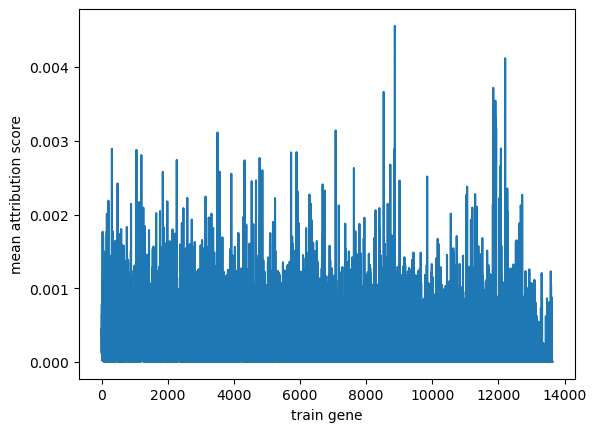

In [7]:
plt.plot(np.arange(len(z_avg)), z_avg);
plt.xlabel('train gene');
plt.ylabel('mean attribution score');

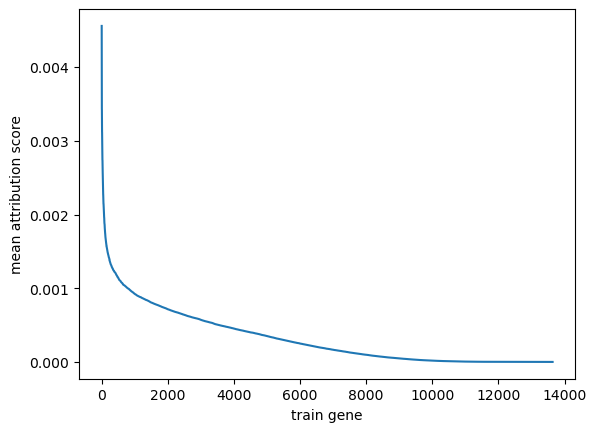

In [8]:
plt.plot(np.arange(len(z_avg)), np.sort(z_avg)[::-1]);
plt.xlabel('train gene');
plt.ylabel('mean attribution score');

In [9]:
z_avg.argmax()

8867

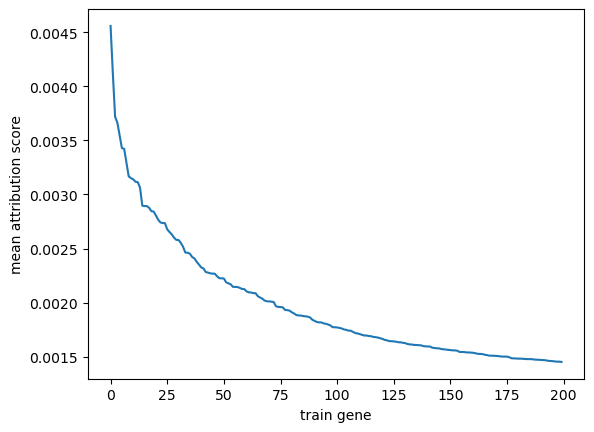

In [10]:
plt.plot(np.arange(len(z_avg))[:200], np.sort(z_avg)[::-1][:200]);
plt.xlabel('train gene');
plt.ylabel('mean attribution score');

In [37]:
np.argsort(z_avg)[::-1][:10]

array([ 8867, 12203, 11843,  8529, 11907, 11876, 11849, 11913, 11930,
       11889])

In [29]:
adata.var

,soma_joinid,feature_name,feature_length,column_1,column_2,column_3,column_4,external_gene_name,gene_biotype,train,highly_variable,means,dispersions,dispersions_norm
ENSG00000000003,31208,TSPAN6,4536,X,100528805,100725413,-,TSPAN6,protein_coding,True,False,1.326663,2.398358,0.457598
ENSG00000000005,30577,TNMD,1476,X,100486498,100683106,+,TNMD,protein_coding,False,True,0.763560,5.822170,3.804221
ENSG00000000419,14679,DPM1,9276,20,50836563,51033171,-,DPM1,protein_coding,False,False,2.037524,2.156650,-0.177009
ENSG00000000457,27677,SCYL3,6883,1,169751327,169947935,-,SCYL3,protein_coding,True,False,0.748549,1.567900,-0.153380
ENSG00000000460,11775,C1orf112,5970,1,169563703,169760311,+,C1orf112,protein_coding,True,False,0.383542,0.659563,-0.811538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000280165,24836,PCDH20,4778,13,61311381,61507989,-,PCDH20,protein_coding,True,False,0.004256,-1.638600,-0.789253
ENSG00000280204,24215,OR1S1,1474,11,58116441,58313049,+,OR1S1,protein_coding,True,False,0.000716,-3.020194,-1.473972
ENSG00000280236,24171,OR12D2,1639,6,29298251,29494859,+,OR12D2,protein_coding,True,False,0.000068,-4.729328,-2.321021
ENSG00000280267,25892,PRAMEF26,1863,1,12951172,13147780,-,PRAMEF26,protein_coding,True,False,0.000006,-6.054641,-2.977847


In [40]:
adata.var[adata.var['train']].iloc[11876]

soma_joinid                    22905
feature_name                  MT-CO1
feature_length                  1542
column_1                          MT
column_2                      -92400
column_3                      104208
column_4                           +
external_gene_name            MT-CO1
gene_biotype          protein_coding
train                           True
highly_variable                False
means                        7.36348
dispersions                 6.885271
dispersions_norm           -0.962483
Name: ENSG00000198804, dtype: object

In [11]:
z_avg_cells = np.asarray(da.abs(z).mean(axis=(0,)))

In [21]:
z_avg_cells.shape

(5792, 13639)

In [38]:
mean_0 = np.abs(z_avg_cells).mean(axis=0)
keep_0 = mean_0 >= np.quantile(mean_0, .98)

mean_1 = np.abs(z_avg_cells).mean(axis=1)
keep_1 = mean_1 >= np.quantile(mean_1, .98)

In [39]:
len(keep_1)

5792

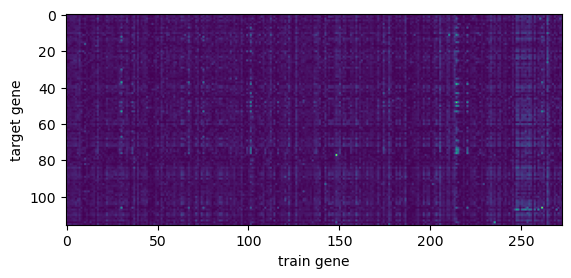

In [40]:
plt.imshow(z_avg_cells[keep_1][:, keep_0]);
plt.xlabel('train gene');
plt.ylabel('target gene');

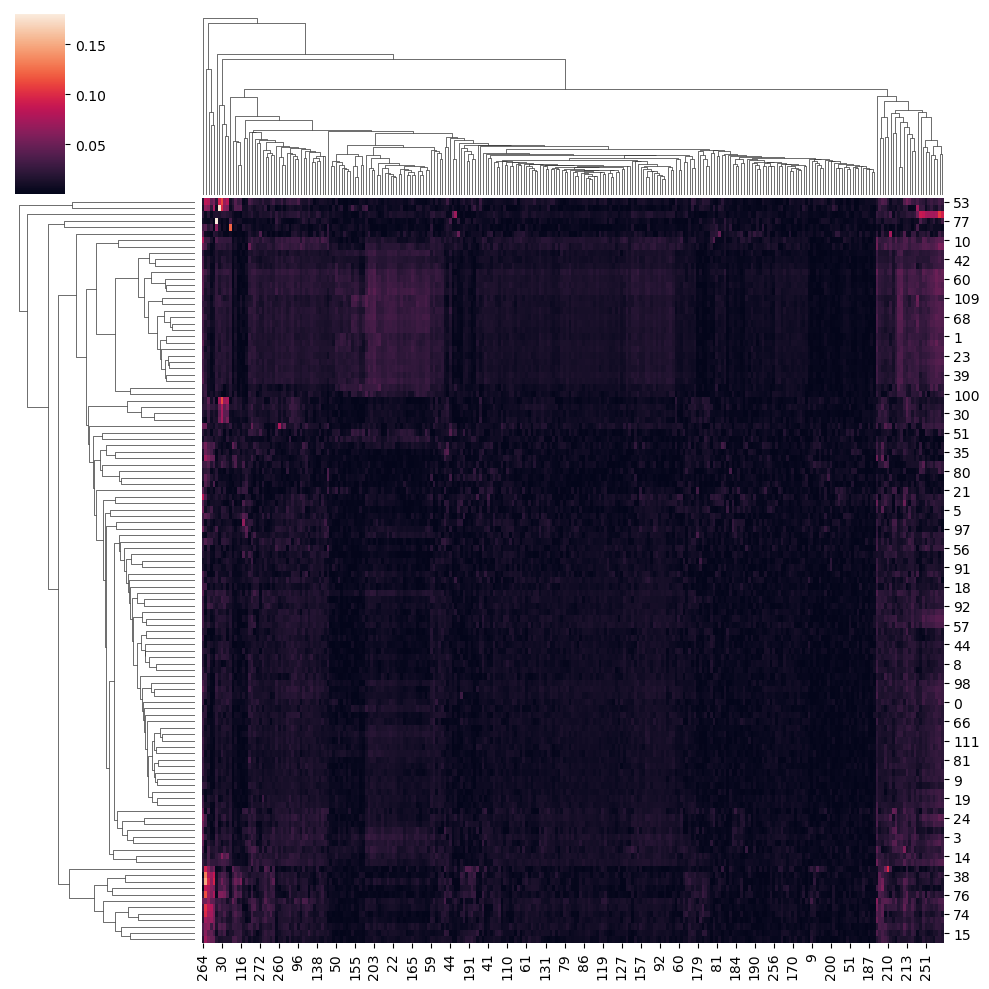

In [41]:
import seaborn as sns
sns.clustermap(z_avg_cells[keep_1][:, keep_0])

In [ ]:
from scipy.cluster.hierarchy import linkage
keep = np.logical_not(adata.obs['train'])
D = np.mean(np.abs(full_attrs_G_train[keep]), axis=0)[:, :140]

link = linkage(D) # D being the measurement
sns.clustermap(D, row_linkage=link, col_linkage=link)

In [ ]:
diag = np.diagonal(np.mean(np.abs(full_attrs_G_train[keep]), axis=0)[:, :140])
vals = np.mean(adata[:, train_genes].X, axis=0)[:140]

In [ ]:
plt.plot(vals, diag, '.');
plt.xlabel('mean expression')
plt.ylabel('mean self attribution score')

In [ ]:
total_attr = np.mean(np.sum(full_attrs_G_train, axis=-1), axis=0)

In [ ]:
plt.plot(total_attr, diag, '.');
plt.xlabel('total attribution');
plt.ylabel('mean self attribution score');

In [ ]:
plt.plot(vals, total_attr, '.');
plt.xlabel('mean expression');
plt.ylabel('total attribution');

In [ ]:
keep = np.logical_not(adata.obs['train'])
D = np.mean(np.abs(full_attrs_G_test[keep]), axis=0)
sns.clustermap(D)

In [ ]:
D.shape

In [ ]:
from rosa.utils import score_predictions, plot_expression_and_correlation, plot_marker_gene_heatmap


adata_test, results = score_predictions(adata)

In [ ]:
plot_expression_and_correlation(adata_test, results)

In [ ]:
import numpy as np


marker_genes = adata_test.var[adata_test.var['highly_variable']]['feature_name'].values
np.random.seed(42)
marker_genes = np.random.choice(marker_genes, 50)

plot_marker_gene_heatmap(adata_test, marker_genes)

In [ ]:
marker_genes_dict = adata_test.obs.set_index('label').to_dict()['marker_feature_name']
plot_marker_gene_heatmap(adata_test, marker_genes_dict)